In [1]:
#MLP with generalized backprop
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [11]:
class Layer:
    
    def __init__(self, params, input_layer):
        self.input_layer = input_layer
        self.params = params
        #input is our input 
        self.val = None
        self.grads = []
        
    def forward(self):
        pass
    
    def bprop(self,z):
        pass
    
    def get_params(self):
        return self.params
    
    def get_value(self):
        return self.val
    
    def update(self):
        pass
    
    
class Input(Layer):
    def __init__(self,batch_size = 32):
        self.bs = batch_size
        self.params = []
        self.val = None
        self.input_layer = None
        self.grads = []
        self.k = 0
        
    def update_inputs(self,x):
        self.val = x
        
    def forward(self):
        if self.val is None:
            raise ValueError("You have not specified an input!")
        return self.val
    
    def bprop(self):
        return [1]
    
    
    
class Fully_Connected(Layer):
    
    def __init__(self, n_in, n_out, input_layer, w = None, b = None, l2_reg = False):
        #For debugging, in case you want to specify a weight + bias
        np.random.seed(314159265)
        
        if not w is None:
            self.w = w
        else:
            self.w = np.random.randn(n_in,n_out) * np.sqrt(2. / n_in)
        
        if not b is None:
            self.b = b
        else:
            self.b = np.random.randn(1,n_out) * np.sqrt(2. / n_in)
            
        self.l2_reg = l2_reg
        
        super().__init__([self.w, self.b], input_layer)
        
    def forward(self):
        if not self.input_layer:
            raise ValueError('There is no input!')
            
        #x should be NxM, N = number of examples, M = number of features
        self.val = self.input_layer.get_value().dot(self.w) + self.b
        return self.val
    
    def bprop(self,z):
        #Since this is a feedforward layer, we want the gradients wrt three variables:
        #Our input x, our weights w, and our biases b.
        #We only need to return the partial wrt our input, and can save the rest for
        #updating
        
        #da_i / dw_i = h_i-1.T * dL/da_i
        self.grads = [self.input_layer.get_value().T.dot(z), np.sum(z,axis=0,keepdims=True)]
        
        if self.l2_reg:
            global lamb
            self.grads[0] -= 2 * lamb * self.w
        
        return z.dot(self.w.T)
    
    def update(self):
        global learning_rate
        self.w += learning_rate * self.grads[0]
        self.b += learning_rate * self.grads[1]
            
    
class Relu(Layer):
    
    def __init__(self, input_layer):
        super().__init__([],input_layer)
        
    def relu(self,x):
        return np.maximum(x,0)
        
    def forward(self):
        if not self.input_layer:
            raise ValueError('There is no input!')
            
        self.val = self.relu(self.input_layer.get_value())
        return self.val
    
    def bprop(self,z):
        return (self.input_layer.get_value() > 0) * 1. * z
    

class Softmax_with_Multiclass_Crossentropy(Layer):
    
    def __init__(self,input_layer):
        selfy_true = None
        super().__init__([],input_layer)
        
    def softmax(self,x):
        return np.exp(x)  / np.sum(np.exp(x) , axis=1, keepdims=True)
    
    def update_gt(self, y_true):
        #y_true should be a one-hot encoded vector
        self.y_true = y_true
    
    def forward(self):
        if not self.input_layer:
            raise ValueError('There is no input!')
            
        self.y_pred = self.softmax(self.input_layer.get_value())
        self.val = - np.multiply(self.y_true, np.log(self.y_pred)).mean()
        return self.val
    
    def bprop(self,z=1):
        #Usually the output layer, so dL/dL = 1 = z
        return self.y_true - self.y_pred
    
    def get_probs(self):
        if self.y_pred is None:
            raise ValueError('You have not computed a probability matrix yet!')
            
        return self.y_pred
    

In [12]:
def forward_propagate(layers):
    act = []
    for layer in layers:
        act.append(layer.forward())
    return act

def back_propagate(layers):
    grads = []
    g_complete = []

    #We use only the second to end layers, so as to avoid backpropagating through the input
    for ind,layer in enumerate(reversed(layers[1:])):
        if ind == 0:
            grads.append(layer.bprop(z = 1))
            g_complete.append(layer.bprop(z = 1))
        else:
            g = layer.bprop(grads.pop())
            grads.append(g)
            g_complete.append(g)
            
    return g_complete

def update(layers):
    for layer in layers:
        layer.update()
        

In [15]:
#Requires mnist in CSV format.
train_fp = 'mnist_train.csv'
test_fp = 'mnist_test.csv'

def open_file(fp):
    with open(fp,'r') as f:
        d = csv.reader(f)
        d = np.array(list(d))
        y = d[:,0]
        x = d[:,1:]
        y = y.astype(np.uint8)
        
        y_hot = np.zeros((y.shape[0],np.unique(y).shape[0]))
        for i in np.unique(y):
            y_hot[:,i][y == i] = 1
        
        x = x.astype(np.float32)
        #We standardize our data
        x = (x - np.mean(x,axis=1,keepdims=True)) / np.std(x,axis=1,keepdims=True)
        return x,y_hot
    return None

def shuffle(x,y):
    assert x.shape[0] == y.shape[0]
    inds = np.random.permutation(np.arange(x.shape[0]))
    return x[inds], y[inds]

x_train, y_train = open_file(train_fp)
x_test, y_test = open_file(test_fp)

x_train, y_train = shuffle(x_train,y_train)
x_test, y_test = shuffle(x_test, y_test)

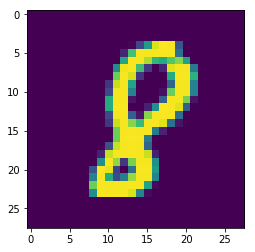

In [16]:
#Plot some images
i = np.random.randint(0,100)
plt.imshow(x_train[i].reshape((28,28)))

In [17]:
bs = 64

layers = []
layers.append(Input(batch_size=bs))
layers.append(Fully_Connected(784,250,layers[-1]))
layers.append(Relu(layers[-1]))
layers.append(Fully_Connected(250,50,layers[-1]))
layers.append(Relu(layers[-1]))
layers.append(Fully_Connected(50,10,layers[-1]))
layers.append(Softmax_with_Multiclass_Crossentropy(layers[-1]))


In [18]:
learning_rate = 1e-4
lamb = 0
iterations = 10000

losses = [[],[],[],[]]
k = 0
for it in range(iterations):
    if (k+1) * bs > x_train.shape[0]:
        k = 0
    
    x_batch = x_train[k * bs: (k+1) * bs]
    y_batch = y_train[k * bs: (k+1) * bs]
    
    #update input and output layers
    layers[0].update_inputs(x_batch)
    layers[-1].update_gt(y_batch)
    
    act = forward_propagate(layers)
    g = back_propagate(layers)
    update(layers)
    
    train_loss = act[-1]
    
    if it%500 == 0:
        
        y_train_preds = layers[-1].get_probs()
        tp = np.argmax(y_train_preds,axis=1) == np.argmax(y_batch,axis=1)
        train_acc = sum(tp) / len(tp)
        
        layers[0].update_inputs(x_test)
        layers[-1].update_gt(y_test)
        act = forward_propagate(layers)
        y_val_preds = layers[-1].get_probs()
        
        tp = np.argmax(y_val_preds,axis=1) == np.argmax(y_test,axis=1)
        val_acc =  sum(tp) / len(tp)
        val_loss = act[-1]
        
        losses[0].append(val_acc)
        losses[1].append(train_acc)
        
        losses[2].append(val_loss)
        losses[3].append(train_loss)
        
        print("Loss: %f | Val Acc: %f | Train Acc: %f" % (train_loss, val_acc, train_acc))
    
    k += 1

Loss: 0.250068 | Val Acc: 0.170700 | Train Acc: 0.156250
Loss: 0.031849 | Val Acc: 0.896800 | Train Acc: 0.906250
Loss: 0.034475 | Val Acc: 0.917400 | Train Acc: 0.890625
Loss: 0.013019 | Val Acc: 0.927700 | Train Acc: 0.968750
Loss: 0.032925 | Val Acc: 0.935900 | Train Acc: 0.906250
Loss: 0.012886 | Val Acc: 0.941000 | Train Acc: 0.968750
Loss: 0.011377 | Val Acc: 0.945000 | Train Acc: 0.968750
Loss: 0.010711 | Val Acc: 0.948400 | Train Acc: 0.953125
Loss: 0.015578 | Val Acc: 0.951800 | Train Acc: 0.953125
Loss: 0.013350 | Val Acc: 0.953300 | Train Acc: 0.968750
Loss: 0.022860 | Val Acc: 0.953900 | Train Acc: 0.984375
Loss: 0.013469 | Val Acc: 0.956900 | Train Acc: 0.968750
Loss: 0.007834 | Val Acc: 0.958800 | Train Acc: 0.968750
Loss: 0.006286 | Val Acc: 0.958900 | Train Acc: 0.984375
Loss: 0.011389 | Val Acc: 0.960600 | Train Acc: 0.953125
Loss: 0.012964 | Val Acc: 0.962400 | Train Acc: 0.968750
Loss: 0.016590 | Val Acc: 0.963300 | Train Acc: 0.921875
Loss: 0.007986 | Val Acc: 0.964

In [19]:
def visualize_losses(losses):
    #Plot Accuracy Over Time
    l1, = plt.plot(np.arange(len(losses[0])),losses[0])
    l2, = plt.plot(np.arange(len(losses[1])),losses[1])
    plt.legend([l1,l2],['Val Acc','Train Acc'])
    plt.title('Accuracy over Time')
    #plt.show()
    #plt.savefig('aot.png',bbox_inches='tight')
    plt.close()
    
    #Plot Loss Over Time
    l1, = plt.plot(np.arange(len(losses[2])),losses[2])
    l2, = plt.plot(np.arange(len(losses[3])),losses[3])
    plt.legend([l1,l2],['Val Loss', 'Train Loss'])
    plt.title('Crossentropy Loss Over Time')
    #plt.savefig('lot.png',bbox_inches='tight')
    #plt.show()

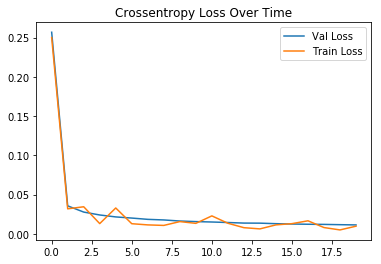

In [20]:
visualize_losses(losses)